In [49]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
from numpy import loadtxt
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

#### Details of this section 
- the original dataset with text processing is imported and ran on the LSTM model
- for the initial model, we used the train and test sets which were split in the preprocessing.ipynb
- the weights which were derived with the use of the GloVe algorithm in the preprocessing.ipynb were imported as well 
- weights were called and used for the embedding layer for the neural networks
- for the tuning portion of the LSTM Model, the KFold-validation was applied to obtain the best batch-size and number of neurons in the LSTM layer
- After obtaining the best model, we will apply on the original train and test dataset and the upsampled train and test set (original dataset + backtranslated data set)

## LSTM-A

In [7]:
#import the train and test files for financial news
fnews_Xtrain = loadtxt('data/train/fnews_Xtrain_.csv', delimiter=',')
fnews_Xtest = loadtxt('data/test/fnews_Xtest_.csv', delimiter=',')
fnews_ytrain = loadtxt('data/train/fnews_ytrain_.csv',delimiter=',')
fnews_ytest = loadtxt('data/test/fnews_ytest_.csv',delimiter=',')

#original data before train and test split
fnews_y = loadtxt('data/test/fnews_y_.csv',delimiter=',')
fnews_X = loadtxt('data/test/fnews_X_.csv',delimiter=',')

In [3]:
#convert to array of integers from full precision
fnews_Xtrain=fnews_Xtrain.astype(int)
fnews_Xtest=fnews_Xtest.astype(int)
fnews_ytrain=fnews_ytrain.astype(int)
fnews_ytest=fnews_ytest.astype(int)

In [4]:
#import the weights
fnews_weights = loadtxt('data/weights/weights_fnews_.csv', delimiter=',')

In [5]:
#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 38) ytrain: (3876, 3)
Xtest: (970, 38) ytest: (970, 3)


In [6]:
fnews_weights.shape

(9243, 100)

#### Building of the LSTM Model

In [68]:
def LSTM_Model_1(neurons, learning_rate):
    
    
    model = Sequential()
    
    model.add(Embedding(fnews_weights.shape[0],fnews_weights.shape[1], weights = [fnews_weights],
                       input_length = 38))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(neurons, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'acc'])
    
    return model

model = LSTM_Model_1(38, 0.01)

#### Callback: Early stopping with patience of 3

In [12]:
# set callbacks to ensure model does not overfit. Ensures training of network is stopped when 
# the validation error starts increasing
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3)

#### Training of model without any tuning to the parameters

#### To have a rough gauge of the number of epoch to run before the overfitting occurs, we will be trying out 3 different epochs of 10, 30 and 50.
#### All other parameters will be as follows:
- learning rate = 0.01
- batch size = 32
- neurons in LSTM layer = 38

##### Varying the epoch 
epoch = 10
learning rate = 0.01
batch size = 64
neuron in LSTM layer = 38

In [23]:
start = time.time()
model= LSTM_Model_1(38, 0.01)
history = model.fit(
    fnews_Xtrain, 
    fnews_ytrain, 
    epochs = 10,
    batch_size = 32,
    validation_data = (fnews_Xtest, fnews_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/10
122/122 [==============================] - 10s 38ms/step - loss: 0.9564 - accuracy: 0.5702 - precision: 0.6195 - recall: 0.3831 - acc: 0.5702 - val_loss: 0.9217 - val_accuracy: 0.5887 - val_precision: 0.5960 - val_recall: 0.5505 - val_acc: 0.5887
Epoch 2/10
122/122 [==============================] - 4s 31ms/step - loss: 0.8985 - accuracy: 0.6112 - precision: 0.6453 - recall: 0.5328 - acc: 0.6112 - val_loss: 0.8827 - val_accuracy: 0.6021 - val_precision: 0.6355 - val_recall: 0.5536 - val_acc: 0.6021
Epoch 3/10
122/122 [==============================] - 5s 42ms/step - loss: 0.8717 - accuracy: 0.6192 - precision: 0.6634 - recall: 0.5498 - acc: 0.6192 - val_loss: 0.8571 - val_accuracy: 0.6134 - val_precision: 0.6538 - val_recall: 0.5433 - val_acc: 0.6134
Epoch 4/10
122/122 [==============================] - 5s 43ms/step - loss: 0.8510 - accuracy: 0.6246 - precision: 0.6746 - recall: 0.5488 - acc: 0.6246 - val_loss: 0.8378 - val_accuracy: 0.6278 - val_precision: 0.6787 - val_reca

time taken: 58.67271900177002


Text(0.5, 0, 'Number of Epochs')

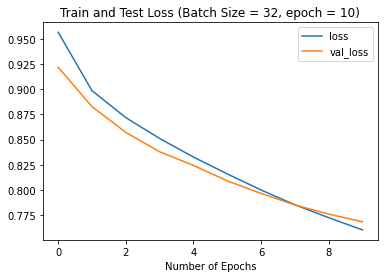

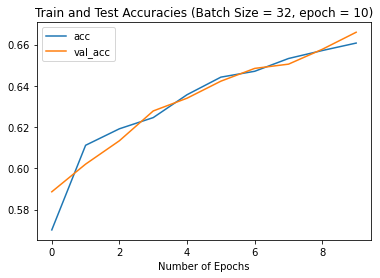

In [24]:
#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (Batch Size = 32, epoch = 10)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (Batch Size = 32, epoch = 10)")
ax1.set_xlabel("Number of Epochs")

#### Observations
- While the test and training accuracies appears to converge before the end of 10 epochs, the number of epochs seems slightly too short to make a definite conclusion if the train and test loss will  converge further with higher number of epoch or diverge instead.

##### Varying the epoch 
epoch = 30
learning rate = 0.01
batch size = 64
neuron in LSTM layer = 38

In [25]:
start = time.time()
model= LSTM_Model_1(38, 0.01)
history = model.fit(
    fnews_Xtrain, 
    fnews_ytrain, 
    epochs = 30,
    batch_size = 32,
    validation_data = (fnews_Xtest, fnews_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/30
122/122 [==============================] - 14s 53ms/step - loss: 0.9277 - accuracy: 0.5949 - precision: 0.6550 - recall: 0.4192 - acc: 0.5949 - val_loss: 0.9075 - val_accuracy: 0.6103 - val_precision: 0.6667 - val_recall: 0.3753 - val_acc: 0.6103
Epoch 2/30
122/122 [==============================] - 6s 45ms/step - loss: 0.8815 - accuracy: 0.6197 - precision: 0.6516 - recall: 0.5433 - acc: 0.6197 - val_loss: 0.8671 - val_accuracy: 0.6175 - val_precision: 0.6633 - val_recall: 0.5340 - val_acc: 0.6175
Epoch 3/30
122/122 [==============================] - 5s 41ms/step - loss: 0.8632 - accuracy: 0.6220 - precision: 0.6566 - recall: 0.5490 - acc: 0.6220 - val_loss: 0.8507 - val_accuracy: 0.6186 - val_precision: 0.6646 - val_recall: 0.5474 - val_acc: 0.6186
Epoch 4/30
122/122 [==============================] - 5s 41ms/step - loss: 0.8502 - accuracy: 0.6259 - precision: 0.6647 - recall: 0.5513 - acc: 0.6259 - val_loss: 0.8384 - val_accuracy: 0.6268 - val_precision: 0.6761 - val_reca

time taken: 170.22473311424255


Text(0.5, 0, 'Number of Epochs')

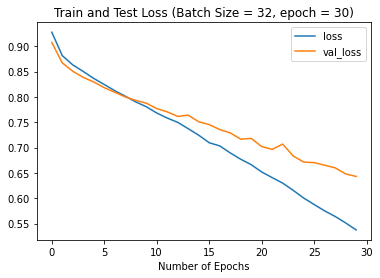

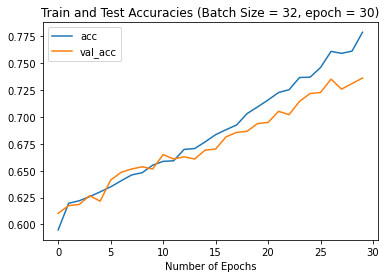

In [26]:
#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (Batch Size = 32, epoch = 30)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (Batch Size = 32, epoch = 30)")
ax1.set_xlabel("Number of Epochs")

#### Observations
- With the increase in number of epochs, we observed that the train and test sets starts to diverge after the 10 epoch and does not appear to converge again

##### Varying the epoch 
epoch = 50
learning rate = 0.01
batch size = 64
neuron in LSTM layer = 38

In [27]:
start = time.time()
model= LSTM_Model_1(38, 0.01)
history = model.fit(
    fnews_Xtrain, 
    fnews_ytrain, 
    epochs = 50,
    batch_size = 32,
    validation_data = (fnews_Xtest, fnews_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/50
122/122 [==============================] - 12s 50ms/step - loss: 0.9765 - accuracy: 0.5426 - precision: 0.6173 - recall: 0.3517 - acc: 0.5426 - val_loss: 0.9330 - val_accuracy: 0.5948 - val_precision: 0.6555 - val_recall: 0.4454 - val_acc: 0.5948
Epoch 2/50
122/122 [==============================] - 6s 46ms/step - loss: 0.8916 - accuracy: 0.6135 - precision: 0.6490 - recall: 0.5506 - acc: 0.6135 - val_loss: 0.8859 - val_accuracy: 0.6082 - val_precision: 0.6553 - val_recall: 0.5567 - val_acc: 0.6082
Epoch 3/50
122/122 [==============================] - 5s 42ms/step - loss: 0.8635 - accuracy: 0.6251 - precision: 0.6679 - recall: 0.5619 - acc: 0.6251 - val_loss: 0.8594 - val_accuracy: 0.6206 - val_precision: 0.6637 - val_recall: 0.5474 - val_acc: 0.6206
Epoch 4/50
122/122 [==============================] - 5s 42ms/step - loss: 0.8443 - accuracy: 0.6293 - precision: 0.6767 - recall: 0.5617 - acc: 0.6293 - val_loss: 0.8400 - val_accuracy: 0.6402 - val_precision: 0.6835 - val_reca

Epoch 33/50
122/122 [==============================] - 11s 94ms/step - loss: 0.4477 - accuracy: 0.8197 - precision: 0.8465 - recall: 0.7838 - acc: 0.8197 - val_loss: 0.6289 - val_accuracy: 0.7351 - val_precision: 0.7589 - val_recall: 0.7041 - val_acc: 0.7351
Epoch 34/50
122/122 [==============================] - 11s 90ms/step - loss: 0.4330 - accuracy: 0.8310 - precision: 0.8564 - recall: 0.8013 - acc: 0.8310 - val_loss: 0.6448 - val_accuracy: 0.7351 - val_precision: 0.7519 - val_recall: 0.7124 - val_acc: 0.7351
Epoch 35/50
122/122 [==============================] - 12s 97ms/step - loss: 0.4247 - accuracy: 0.8308 - precision: 0.8520 - recall: 0.7975 - acc: 0.8308 - val_loss: 0.6331 - val_accuracy: 0.7351 - val_precision: 0.7538 - val_recall: 0.7134 - val_acc: 0.7351
Epoch 36/50
122/122 [==============================] - 15s 121ms/step - loss: 0.4190 - accuracy: 0.8336 - precision: 0.8598 - recall: 0.8086 - acc: 0.8336 - val_loss: 0.6401 - val_accuracy: 0.7381 - val_precision: 0.7563 - 

time taken: 542.9441788196564


Text(0.5, 0, 'Number of Epochs')

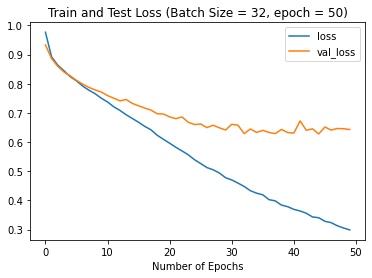

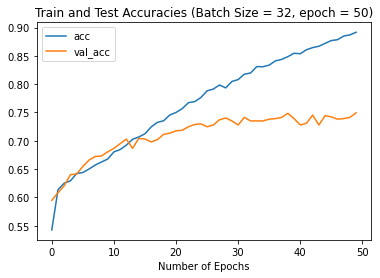

In [28]:
#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (Batch Size = 32, epoch = 50)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (Batch Size = 32, epoch = 50)")
ax1.set_xlabel("Number of Epochs")

#### Observations
- With the increase in number of epochs, we observed that the train and test sets starts to diverge after the 10 epoch and does not appear to converge again. Although the training accuracies continues to increase while the losses decrease, the model is likely to be overfitted as it got used to the training data and thus losing its value as a predictive tool.

#### Conclusion on number of epoch: Based on the different epoch tested out, we will be using 15 epochs for the remaining models. 

#### Tuning of the hyperparameters by using the KFold Validation method
- find out which is the optimal batch size across [16, 32, 64, 128]

In [56]:
#tune the hyper parameters by using KFold Validation (batch size)

no_of_fold = 5
batch_size = [16, 32, 64, 128, 256]
kf = KFold(n_splits = no_of_fold)

csv_logger = tf.keras.callbacks.CSVLogger('fnews_batchsize.csv', separator=",")


def train_exp(fnews_X, fnews_y):
    results = pd.DataFrame(columns = ["Fold Number", "Batch Size",
                                      "Cross Validation Accuracy", "Time Taken"])
    acc = []
    fold_no = 1
    model = LSTM_Model_1(38, 0.01)
    for train, test in kf.split(fnews_X, fnews_y):
        fnews_Xtrain, fnews_Xtest, fnews_ytrain, fnews_ytest = train_test_split(fnews_X, fnews_y, test_size=0.2, random_state=0) 
        acc_ = []
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        for batch in batch_size:
            print(f'Training for batch size {batch}')
            start = time.time()
            history_kfold_bs = model.fit(
                                fnews_Xtrain, 
                                fnews_ytrain, 
                                epochs = 15,
                                batch_size = batch,
                                validation_data = (fnews_Xtest, fnews_ytest),
                                verbose = 1,
                                callbacks = [early_stop,csv_logger]
                            )
            end = time.time()
            time_taken =  end - start
            acc_.append(min(history_kfold_bs.history['val_accuracy']))
            val_acc = min(history_kfold_bs.history['val_accuracy'])
            #add results to dataframe
            insert_row = {'Fold Number': fold_no, 'Batch Size':batch, 
                          'Cross Validation Accuracy': val_acc, 
                          'Time Taken': time_taken}
            results = pd.concat([results, pd.DataFrame([insert_row])])
        fold_no = fold_no + 1
        acc.append(acc_)
    acc_err = np.mean(np.array(acc), axis = 0)
    return results, acc_err

In [57]:
table_batchsizes, acc_err_bs = train_exp(fnews_X, fnews_y)

------------------------------------------------------------------------
Training for fold 1 ...
Training for batch size 16
Epoch 1/15
243/243 [==============================] - 23s 74ms/step - loss: 0.9287 - accuracy: 0.5826 - precision: 0.6221 - recall: 0.4370 - acc: 0.5826 - val_loss: 0.8907 - val_accuracy: 0.5948 - val_precision: 0.6517 - val_recall: 0.5402 - val_acc: 0.5948
Epoch 2/15
243/243 [==============================] - 20s 83ms/step - loss: 0.8585 - accuracy: 0.6220 - precision: 0.6687 - recall: 0.5292 - acc: 0.6220 - val_loss: 0.8571 - val_accuracy: 0.6237 - val_precision: 0.6692 - val_recall: 0.5505 - val_acc: 0.6237
Epoch 3/15
243/243 [==============================] - 20s 83ms/step - loss: 0.8236 - accuracy: 0.6352 - precision: 0.6873 - recall: 0.5335 - acc: 0.6352 - val_loss: 0.8317 - val_accuracy: 0.6474 - val_precision: 0.7081 - val_recall: 0.5402 - val_acc: 0.6474
Epoch 4/15
243/243 [==============================] - 20s 84ms/step - loss: 0.7963 - accuracy: 0.6530 

61/61 [==============================] - 8s 133ms/step - loss: 0.3277 - accuracy: 0.8826 - precision: 0.8966 - recall: 0.8633 - acc: 0.8826 - val_loss: 0.6226 - val_accuracy: 0.7474 - val_precision: 0.7594 - val_recall: 0.7320 - val_acc: 0.7474
Epoch 3/15
61/61 [==============================] - 8s 137ms/step - loss: 0.3247 - accuracy: 0.8811 - precision: 0.8945 - recall: 0.8620 - acc: 0.8811 - val_loss: 0.6212 - val_accuracy: 0.7433 - val_precision: 0.7597 - val_recall: 0.7299 - val_acc: 0.7433
Epoch 4/15
61/61 [==============================] - 8s 130ms/step - loss: 0.3167 - accuracy: 0.8826 - precision: 0.8947 - recall: 0.8617 - acc: 0.8826 - val_loss: 0.6246 - val_accuracy: 0.7454 - val_precision: 0.7621 - val_recall: 0.7330 - val_acc: 0.7454
Epoch 5/15
61/61 [==============================] - 8s 123ms/step - loss: 0.3111 - accuracy: 0.8860 - precision: 0.9050 - recall: 0.8700 - acc: 0.8860 - val_loss: 0.6227 - val_accuracy: 0.7423 - val_precision: 0.7580 - val_recall: 0.7299 - val

Epoch 4/15
16/16 [==============================] - 8s 524ms/step - loss: 0.2334 - accuracy: 0.9267 - precision: 0.9371 - recall: 0.9146 - acc: 0.9267 - val_loss: 0.6538 - val_accuracy: 0.7443 - val_precision: 0.7614 - val_recall: 0.7371 - val_acc: 0.7443
Epoch 5/15
16/16 [==============================] - 9s 540ms/step - loss: 0.2299 - accuracy: 0.9257 - precision: 0.9378 - recall: 0.9141 - acc: 0.9257 - val_loss: 0.6502 - val_accuracy: 0.7412 - val_precision: 0.7537 - val_recall: 0.7289 - val_acc: 0.7412
Epoch 6/15
16/16 [==============================] - 9s 532ms/step - loss: 0.2298 - accuracy: 0.9254 - precision: 0.9352 - recall: 0.9156 - acc: 0.9254 - val_loss: 0.6566 - val_accuracy: 0.7392 - val_precision: 0.7556 - val_recall: 0.7268 - val_acc: 0.7392
Epoch 7/15
16/16 [==============================] - 9s 563ms/step - loss: 0.2292 - accuracy: 0.9265 - precision: 0.9372 - recall: 0.9128 - acc: 0.9265 - val_loss: 0.6584 - val_accuracy: 0.7381 - val_precision: 0.7511 - val_recall: 0

122/122 [==============================] - 17s 140ms/step - loss: 0.0989 - accuracy: 0.9794 - precision: 0.9824 - recall: 0.9768 - acc: 0.9794 - val_loss: 0.7716 - val_accuracy: 0.7546 - val_precision: 0.7663 - val_recall: 0.7505 - val_acc: 0.7546
Epoch 11/15
122/122 [==============================] - 16s 133ms/step - loss: 0.0938 - accuracy: 0.9807 - precision: 0.9816 - recall: 0.9786 - acc: 0.9807 - val_loss: 0.7636 - val_accuracy: 0.7619 - val_precision: 0.7692 - val_recall: 0.7557 - val_acc: 0.7619
Epoch 12/15
122/122 [==============================] - 17s 143ms/step - loss: 0.0896 - accuracy: 0.9837 - precision: 0.9850 - recall: 0.9796 - acc: 0.9837 - val_loss: 0.8067 - val_accuracy: 0.7546 - val_precision: 0.7618 - val_recall: 0.7515 - val_acc: 0.7546
Epoch 13/15
122/122 [==============================] - 16s 133ms/step - loss: 0.0921 - accuracy: 0.9817 - precision: 0.9834 - recall: 0.9786 - acc: 0.9817 - val_loss: 0.7700 - val_accuracy: 0.7588 - val_precision: 0.7667 - val_recal

16/16 [==============================] - 13s 824ms/step - loss: 0.0616 - accuracy: 0.9905 - precision: 0.9917 - recall: 0.9886 - acc: 0.9905 - val_loss: 0.8100 - val_accuracy: 0.7629 - val_precision: 0.7675 - val_recall: 0.7588 - val_acc: 0.7629
Epoch 5/15
16/16 [==============================] - 13s 787ms/step - loss: 0.0612 - accuracy: 0.9912 - precision: 0.9930 - recall: 0.9892 - acc: 0.9912 - val_loss: 0.8083 - val_accuracy: 0.7619 - val_precision: 0.7659 - val_recall: 0.7557 - val_acc: 0.7619
Epoch 6/15
16/16 [==============================] - 13s 813ms/step - loss: 0.0614 - accuracy: 0.9917 - precision: 0.9930 - recall: 0.9894 - acc: 0.9917 - val_loss: 0.8117 - val_accuracy: 0.7649 - val_precision: 0.7701 - val_recall: 0.7598 - val_acc: 0.7649
------------------------------------------------------------------------
Training for fold 3 ...
Training for batch size 16
Epoch 1/15
243/243 [==============================] - 28s 117ms/step - loss: 0.0905 - accuracy: 0.9783 - precision: 

122/122 [==============================] - 22s 176ms/step - loss: 0.0372 - accuracy: 0.9956 - precision: 0.9964 - recall: 0.9941 - acc: 0.9956 - val_loss: 0.9010 - val_accuracy: 0.7670 - val_precision: 0.7697 - val_recall: 0.7649 - val_acc: 0.7670
Epoch 15/15
122/122 [==============================] - 20s 168ms/step - loss: 0.0367 - accuracy: 0.9956 - precision: 0.9964 - recall: 0.9948 - acc: 0.9956 - val_loss: 0.9143 - val_accuracy: 0.7660 - val_precision: 0.7692 - val_recall: 0.7629 - val_acc: 0.7660
Training for batch size 64
Epoch 1/15
61/61 [==============================] - 14s 233ms/step - loss: 0.0336 - accuracy: 0.9948 - precision: 0.9956 - recall: 0.9941 - acc: 0.9948 - val_loss: 0.9034 - val_accuracy: 0.7680 - val_precision: 0.7716 - val_recall: 0.7629 - val_acc: 0.7680
Epoch 2/15
61/61 [==============================] - 13s 211ms/step - loss: 0.0319 - accuracy: 0.9956 - precision: 0.9966 - recall: 0.9951 - acc: 0.9956 - val_loss: 0.9036 - val_accuracy: 0.7711 - val_precisio

122/122 [==============================] - 8s 62ms/step - loss: 0.0302 - accuracy: 0.9948 - precision: 0.9954 - recall: 0.9943 - acc: 0.9948 - val_loss: 0.9351 - val_accuracy: 0.7608 - val_precision: 0.7643 - val_recall: 0.7588 - val_acc: 0.7608
Training for batch size 64
Epoch 1/15
61/61 [==============================] - 5s 88ms/step - loss: 0.0263 - accuracy: 0.9961 - precision: 0.9972 - recall: 0.9959 - acc: 0.9961 - val_loss: 0.9443 - val_accuracy: 0.7619 - val_precision: 0.7656 - val_recall: 0.7577 - val_acc: 0.7619
Epoch 2/15
61/61 [==============================] - 5s 85ms/step - loss: 0.0246 - accuracy: 0.9956 - precision: 0.9966 - recall: 0.9948 - acc: 0.9956 - val_loss: 0.9450 - val_accuracy: 0.7608 - val_precision: 0.7643 - val_recall: 0.7557 - val_acc: 0.7608
Epoch 3/15
61/61 [==============================] - 5s 88ms/step - loss: 0.0268 - accuracy: 0.9956 - precision: 0.9966 - recall: 0.9956 - acc: 0.9956 - val_loss: 0.9386 - val_accuracy: 0.7588 - val_precision: 0.7627 -

Epoch 1/15
61/61 [==============================] - 10s 159ms/step - loss: 0.0209 - accuracy: 0.9972 - precision: 0.9977 - recall: 0.9966 - acc: 0.9972 - val_loss: 0.9697 - val_accuracy: 0.7629 - val_precision: 0.7669 - val_recall: 0.7598 - val_acc: 0.7629
Epoch 2/15
61/61 [==============================] - 10s 168ms/step - loss: 0.0211 - accuracy: 0.9969 - precision: 0.9977 - recall: 0.9964 - acc: 0.9969 - val_loss: 0.9770 - val_accuracy: 0.7639 - val_precision: 0.7677 - val_recall: 0.7598 - val_acc: 0.7639
Epoch 3/15
61/61 [==============================] - 9s 150ms/step - loss: 0.0216 - accuracy: 0.9969 - precision: 0.9974 - recall: 0.9964 - acc: 0.9969 - val_loss: 0.9746 - val_accuracy: 0.7619 - val_precision: 0.7654 - val_recall: 0.7567 - val_acc: 0.7619
Epoch 4/15
61/61 [==============================] - 9s 144ms/step - loss: 0.0219 - accuracy: 0.9951 - precision: 0.9961 - recall: 0.9946 - acc: 0.9951 - val_loss: 0.9737 - val_accuracy: 0.7619 - val_precision: 0.7669 - val_recall:

#### Plot the scatter plot for the batch sizes against the cross validation accuracies

Text(0.5, 1.0, 'Test for optimal batch size')

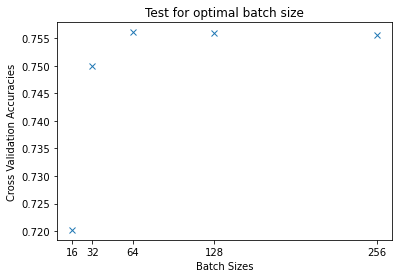

In [58]:
plt.figure(1)
plt.plot(batch_size, acc_err_bs, marker = 'x', linestyle = 'None')
plt.xticks(batch_size)
plt.xlabel('Batch Sizes')
plt.ylabel('Cross Validation Accuracies')
plt.title('Test for optimal batch size')

#### Tuning of the hyperparameters by using the KFold Validation Method
- find out which is the optimal neurons for the LSTM layer across [16, 38, 64, 128]

In [61]:
#tune the hyper parameters by using KFold Validation (neurons)

no_of_fold = 5
neurons = [16, 38, 64, 128]
kf = KFold(n_splits = no_of_fold)

csv_logger = tf.keras.callbacks.CSVLogger('fnews_neurons.csv', separator=",")


def train_exp_1(fnews_X, fnews_y):
    results = pd.DataFrame(columns = ["Fold Number", "Neurons",
                                      "Cross Validation Accuracy", "Time Taken"])
    acc = []
    fold_no = 1
    for train, test in kf.split(fnews_X, fnews_y):
        fnews_Xtrain, fnews_Xtest, fnews_ytrain, fnews_ytest = train_test_split(fnews_X, fnews_y, test_size=0.2, random_state=0) 
        acc_ = []
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        for neuron in neurons:
            model = LSTM_Model_1(neuron, 0.01)
            print(f'Training for neurons {neuron}')
            start = time.time()
            history_kfold_neuron = model.fit(
                                fnews_Xtrain, 
                                fnews_ytrain, 
                                epochs = 15,
                                batch_size = 64,
                                validation_data = (fnews_Xtest, fnews_ytest),
                                verbose = 1,
                                callbacks = [early_stop,csv_logger]
                            )
            end = time.time()
            time_taken =  end - start
            acc_.append(min(history_kfold_neuron.history['val_accuracy']))
            val_acc = min(history_kfold_neuron.history['val_accuracy'])
            #add results to dataframe
            insert_row = {'Fold Number': fold_no, 'Neurons':neuron, 
                          'Cross Validation Accuracy': val_acc, 
                          'Time Taken': time_taken}
            results = pd.concat([results, pd.DataFrame([insert_row])])
        fold_no = fold_no + 1
        acc.append(acc_)
    acc_err = np.mean(np.array(acc), axis = 0)
    return results, acc_err

In [62]:
table_neurons, acc_err_neuron = train_exp_1(fnews_X, fnews_y)

------------------------------------------------------------------------
Training for fold 1 ...
Training for neurons 16
Epoch 1/15
61/61 [==============================] - 13s 70ms/step - loss: 0.9948 - accuracy: 0.5286 - precision: 0.6122 - recall: 0.2273 - acc: 0.5286 - val_loss: 0.9578 - val_accuracy: 0.5948 - val_precision: 0.6763 - val_recall: 0.2175 - val_acc: 0.5948
Epoch 2/15
61/61 [==============================] - 3s 50ms/step - loss: 0.9254 - accuracy: 0.5934 - precision: 0.6142 - recall: 0.4850 - acc: 0.5934 - val_loss: 0.9248 - val_accuracy: 0.5959 - val_precision: 0.6250 - val_recall: 0.4691 - val_acc: 0.5959
Epoch 3/15
61/61 [==============================] - 3s 51ms/step - loss: 0.9119 - accuracy: 0.5975 - precision: 0.6146 - recall: 0.5299 - acc: 0.5975 - val_loss: 0.9132 - val_accuracy: 0.5990 - val_precision: 0.6208 - val_recall: 0.4979 - val_acc: 0.5990
Epoch 4/15
61/61 [==============================] - 3s 51ms/step - loss: 0.9036 - accuracy: 0.5998 - precision: 0

61/61 [==============================] - 5s 84ms/step - loss: 0.9092 - accuracy: 0.5924 - precision: 0.6275 - recall: 0.5302 - acc: 0.5924 - val_loss: 0.9211 - val_accuracy: 0.5876 - val_precision: 0.6837 - val_recall: 0.4278 - val_acc: 0.5876
Epoch 3/15
61/61 [==============================] - 5s 87ms/step - loss: 0.8869 - accuracy: 0.6017 - precision: 0.6465 - recall: 0.5506 - acc: 0.6017 - val_loss: 0.8991 - val_accuracy: 0.6041 - val_precision: 0.6814 - val_recall: 0.4763 - val_acc: 0.6041
Epoch 4/15
61/61 [==============================] - 5s 84ms/step - loss: 0.8707 - accuracy: 0.6117 - precision: 0.6619 - recall: 0.5410 - acc: 0.6117 - val_loss: 0.8806 - val_accuracy: 0.6124 - val_precision: 0.6693 - val_recall: 0.5155 - val_acc: 0.6124
Epoch 5/15
61/61 [==============================] - 5s 86ms/step - loss: 0.8560 - accuracy: 0.6207 - precision: 0.6684 - recall: 0.5493 - acc: 0.6207 - val_loss: 0.8693 - val_accuracy: 0.6258 - val_precision: 0.6776 - val_recall: 0.5113 - val_acc

61/61 [==============================] - 6s 97ms/step - loss: 0.9172 - accuracy: 0.5872 - precision: 0.6250 - recall: 0.5165 - acc: 0.5872 - val_loss: 0.9240 - val_accuracy: 0.5856 - val_precision: 0.6232 - val_recall: 0.5216 - val_acc: 0.5856
Epoch 4/15
61/61 [==============================] - 6s 105ms/step - loss: 0.9054 - accuracy: 0.5988 - precision: 0.6371 - recall: 0.5217 - acc: 0.5988 - val_loss: 0.9125 - val_accuracy: 0.5907 - val_precision: 0.6333 - val_recall: 0.5289 - val_acc: 0.5907
Epoch 5/15
61/61 [==============================] - 7s 109ms/step - loss: 0.8943 - accuracy: 0.6022 - precision: 0.6425 - recall: 0.5338 - acc: 0.6022 - val_loss: 0.9040 - val_accuracy: 0.6041 - val_precision: 0.6470 - val_recall: 0.5196 - val_acc: 0.6041
Epoch 6/15
61/61 [==============================] - 6s 105ms/step - loss: 0.8857 - accuracy: 0.6068 - precision: 0.6514 - recall: 0.5279 - acc: 0.6068 - val_loss: 0.8967 - val_accuracy: 0.6052 - val_precision: 0.6571 - val_recall: 0.5216 - val_

Epoch 5/15
61/61 [==============================] - 6s 93ms/step - loss: 0.8368 - accuracy: 0.6311 - precision: 0.6697 - recall: 0.5550 - acc: 0.6311 - val_loss: 0.8616 - val_accuracy: 0.6258 - val_precision: 0.6839 - val_recall: 0.5309 - val_acc: 0.6258
Epoch 6/15
61/61 [==============================] - 6s 95ms/step - loss: 0.8260 - accuracy: 0.6357 - precision: 0.6804 - recall: 0.5537 - acc: 0.6357 - val_loss: 0.8525 - val_accuracy: 0.6268 - val_precision: 0.6878 - val_recall: 0.5361 - val_acc: 0.6268
Epoch 7/15
61/61 [==============================] - 6s 94ms/step - loss: 0.8145 - accuracy: 0.6373 - precision: 0.6871 - recall: 0.5495 - acc: 0.6373 - val_loss: 0.8453 - val_accuracy: 0.6309 - val_precision: 0.6839 - val_recall: 0.5443 - val_acc: 0.6309
Epoch 8/15
61/61 [==============================] - 6s 99ms/step - loss: 0.8022 - accuracy: 0.6411 - precision: 0.6902 - recall: 0.5552 - acc: 0.6411 - val_loss: 0.8378 - val_accuracy: 0.6309 - val_precision: 0.6912 - val_recall: 0.542

61/61 [==============================] - 6s 100ms/step - loss: 0.9037 - accuracy: 0.5939 - precision: 0.6201 - recall: 0.5601 - acc: 0.5939 - val_loss: 0.9084 - val_accuracy: 0.5928 - val_precision: 0.6134 - val_recall: 0.5660 - val_acc: 0.5928
Epoch 7/15
61/61 [==============================] - 6s 101ms/step - loss: 0.8957 - accuracy: 0.5983 - precision: 0.6301 - recall: 0.5580 - acc: 0.5983 - val_loss: 0.9019 - val_accuracy: 0.5938 - val_precision: 0.6127 - val_recall: 0.5691 - val_acc: 0.5938
Epoch 8/15
61/61 [==============================] - 6s 104ms/step - loss: 0.8876 - accuracy: 0.6011 - precision: 0.6321 - recall: 0.5637 - acc: 0.6011 - val_loss: 0.8951 - val_accuracy: 0.6052 - val_precision: 0.6292 - val_recall: 0.5598 - val_acc: 0.6052
Epoch 9/15
61/61 [==============================] - 6s 99ms/step - loss: 0.8799 - accuracy: 0.6068 - precision: 0.6432 - recall: 0.5596 - acc: 0.6068 - val_loss: 0.8887 - val_accuracy: 0.6072 - val_precision: 0.6367 - val_recall: 0.5546 - val_

Epoch 8/15
61/61 [==============================] - 15s 245ms/step - loss: 0.8041 - accuracy: 0.6471 - precision: 0.7069 - recall: 0.5451 - acc: 0.6471 - val_loss: 0.8204 - val_accuracy: 0.6443 - val_precision: 0.7001 - val_recall: 0.5464 - val_acc: 0.6443
Epoch 9/15
61/61 [==============================] - 16s 255ms/step - loss: 0.7953 - accuracy: 0.6499 - precision: 0.7128 - recall: 0.5526 - acc: 0.6499 - val_loss: 0.8132 - val_accuracy: 0.6495 - val_precision: 0.7012 - val_recall: 0.5515 - val_acc: 0.6495
Epoch 10/15
61/61 [==============================] - 16s 256ms/step - loss: 0.7869 - accuracy: 0.6507 - precision: 0.7196 - recall: 0.5550 - acc: 0.6507 - val_loss: 0.8061 - val_accuracy: 0.6526 - val_precision: 0.7064 - val_recall: 0.5557 - val_acc: 0.6526
Epoch 11/15
61/61 [==============================] - 16s 261ms/step - loss: 0.7783 - accuracy: 0.6576 - precision: 0.7220 - recall: 0.5568 - acc: 0.6576 - val_loss: 0.8000 - val_accuracy: 0.6536 - val_precision: 0.7074 - val_rec

61/61 [==============================] - 3s 44ms/step - loss: 0.8577 - accuracy: 0.6164 - precision: 0.6544 - recall: 0.5477 - acc: 0.6164 - val_loss: 0.8810 - val_accuracy: 0.6062 - val_precision: 0.6378 - val_recall: 0.5464 - val_acc: 0.6062
Epoch 10/15
61/61 [==============================] - 3s 47ms/step - loss: 0.8499 - accuracy: 0.6207 - precision: 0.6631 - recall: 0.5444 - acc: 0.6207 - val_loss: 0.8746 - val_accuracy: 0.6072 - val_precision: 0.6484 - val_recall: 0.5474 - val_acc: 0.6072
Epoch 11/15
61/61 [==============================] - 3s 46ms/step - loss: 0.8425 - accuracy: 0.6246 - precision: 0.6716 - recall: 0.5451 - acc: 0.6246 - val_loss: 0.8683 - val_accuracy: 0.6082 - val_precision: 0.6556 - val_recall: 0.5474 - val_acc: 0.6082
Epoch 12/15
61/61 [==============================] - 3s 45ms/step - loss: 0.8348 - accuracy: 0.6272 - precision: 0.6741 - recall: 0.5444 - acc: 0.6272 - val_loss: 0.8620 - val_accuracy: 0.6124 - val_precision: 0.6637 - val_recall: 0.5412 - val_

Epoch 11/15
61/61 [==============================] - 6s 102ms/step - loss: 0.7824 - accuracy: 0.6556 - precision: 0.7112 - recall: 0.5586 - acc: 0.6556 - val_loss: 0.8099 - val_accuracy: 0.6443 - val_precision: 0.6957 - val_recall: 0.5608 - val_acc: 0.6443
Epoch 12/15
61/61 [==============================] - 6s 105ms/step - loss: 0.7730 - accuracy: 0.6551 - precision: 0.7129 - recall: 0.5684 - acc: 0.6551 - val_loss: 0.8024 - val_accuracy: 0.6557 - val_precision: 0.7096 - val_recall: 0.5567 - val_acc: 0.6557
Epoch 13/15
61/61 [==============================] - 6s 106ms/step - loss: 0.7652 - accuracy: 0.6571 - precision: 0.7218 - recall: 0.5630 - acc: 0.6571 - val_loss: 0.7962 - val_accuracy: 0.6567 - val_precision: 0.7121 - val_recall: 0.5660 - val_acc: 0.6567
Epoch 14/15
61/61 [==============================] - 6s 106ms/step - loss: 0.7576 - accuracy: 0.6620 - precision: 0.7276 - recall: 0.5679 - acc: 0.6620 - val_loss: 0.7901 - val_accuracy: 0.6557 - val_precision: 0.7123 - val_recal

61/61 [==============================] - 3s 45ms/step - loss: 0.8754 - accuracy: 0.6047 - precision: 0.6518 - recall: 0.5550 - acc: 0.6047 - val_loss: 0.8855 - val_accuracy: 0.6113 - val_precision: 0.6594 - val_recall: 0.5608 - val_acc: 0.6113
Epoch 13/15
61/61 [==============================] - 3s 47ms/step - loss: 0.8706 - accuracy: 0.6096 - precision: 0.6576 - recall: 0.5501 - acc: 0.6096 - val_loss: 0.8815 - val_accuracy: 0.6175 - val_precision: 0.6675 - val_recall: 0.5567 - val_acc: 0.6175
Epoch 14/15
61/61 [==============================] - 3s 45ms/step - loss: 0.8647 - accuracy: 0.6104 - precision: 0.6631 - recall: 0.5392 - acc: 0.6104 - val_loss: 0.8775 - val_accuracy: 0.6165 - val_precision: 0.6650 - val_recall: 0.5567 - val_acc: 0.6165
Epoch 15/15
61/61 [==============================] - 3s 44ms/step - loss: 0.8579 - accuracy: 0.6133 - precision: 0.6648 - recall: 0.5402 - acc: 0.6133 - val_loss: 0.8735 - val_accuracy: 0.6175 - val_precision: 0.6679 - val_recall: 0.5495 - val_

Epoch 14/15
61/61 [==============================] - 7s 107ms/step - loss: 0.7463 - accuracy: 0.6793 - precision: 0.7333 - recall: 0.5916 - acc: 0.6793 - val_loss: 0.7928 - val_accuracy: 0.6629 - val_precision: 0.7087 - val_recall: 0.5794 - val_acc: 0.6629
Epoch 15/15
61/61 [==============================] - 7s 114ms/step - loss: 0.7372 - accuracy: 0.6840 - precision: 0.7362 - recall: 0.5970 - acc: 0.6840 - val_loss: 0.7849 - val_accuracy: 0.6588 - val_precision: 0.7100 - val_recall: 0.5804 - val_acc: 0.6588
Training for neurons 128
Epoch 1/15
61/61 [==============================] - 27s 340ms/step - loss: 0.9542 - accuracy: 0.5820 - precision: 0.6378 - recall: 0.3426 - acc: 0.5820 - val_loss: 0.9479 - val_accuracy: 0.6072 - val_precision: 0.6606 - val_recall: 0.3371 - val_acc: 0.6072
Epoch 2/15
61/61 [==============================] - 16s 270ms/step - loss: 0.8869 - accuracy: 0.6169 - precision: 0.6628 - recall: 0.5284 - acc: 0.6169 - val_loss: 0.9074 - val_accuracy: 0.6186 - val_prec

#### Plot the scatter plot for the neurons against the cross validation accuracies

Text(0.5, 1.0, 'Test for optimal neurons')

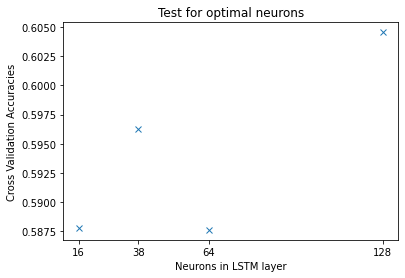

In [63]:
plt.figure(2)
plt.plot(neurons, acc_err_neuron, marker = 'x', linestyle = 'None')
plt.xticks(neurons)
plt.xlabel('Neurons in LSTM layer')
plt.ylabel('Cross Validation Accuracies')
plt.title('Test for optimal neurons')

#### Observations:
- Based on the scatter plot, the optimal number of neurons is 38 as it is the most optimal before leading to a sudden drop in cross validation accuracies

#### The final best model have the following parameters:

- batch size: 64
- neurons:128
- learning rate:0.01

In [79]:
# Applying the final best model on the train and test set 
def LSTM_Model_Best():
    
    
    model = Sequential()
    
    model.add(Embedding(fnews_weights.shape[0],fnews_weights.shape[1], weights = [fnews_weights],
                       input_length = 38))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(38, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'acc'])
    
    return model

model = LSTM_Model_Best()
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, 38, 100)           924300    
                                                                 
 batch_normalization_63 (Bat  (None, 38, 100)          400       
 chNormalization)                                                
                                                                 
 bidirectional_63 (Bidirecti  (None, 76)               42256     
 onal)                                                           
                                                                 
 dense_63 (Dense)            (None, 3)                 231       
                                                                 
Total params: 967,187
Trainable params: 966,987
Non-trainable params: 200
_________________________________________________________________


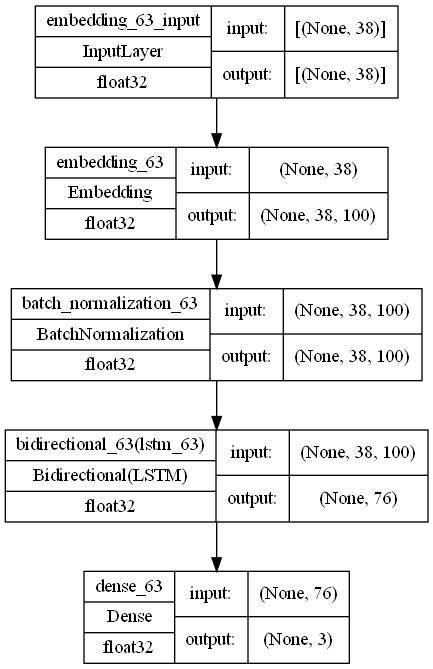

In [80]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,)

In [81]:
start = time.time()
model= LSTM_Model_Best()
history_best = model.fit(
    fnews_Xtrain, 
    fnews_ytrain, 
    epochs = 15,
    batch_size = 64,
    validation_data = (fnews_Xtest, fnews_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/15
61/61 [==============================] - 8s 51ms/step - loss: 0.9838 - accuracy: 0.5343 - precision: 0.6379 - recall: 0.2900 - acc: 0.5343 - val_loss: 0.9256 - val_accuracy: 0.5887 - val_precision: 0.6667 - val_recall: 0.4474 - val_acc: 0.5887
Epoch 2/15
61/61 [==============================] - 2s 38ms/step - loss: 0.9145 - accuracy: 0.5991 - precision: 0.6329 - recall: 0.5338 - acc: 0.5991 - val_loss: 0.8995 - val_accuracy: 0.6041 - val_precision: 0.6580 - val_recall: 0.5216 - val_acc: 0.6041
Epoch 3/15
61/61 [==============================] - 2s 39ms/step - loss: 0.8965 - accuracy: 0.6078 - precision: 0.6473 - recall: 0.5454 - acc: 0.6078 - val_loss: 0.8846 - val_accuracy: 0.6124 - val_precision: 0.6533 - val_recall: 0.5381 - val_acc: 0.6124
Epoch 4/15
61/61 [==============================] - 2s 41ms/step - loss: 0.8843 - accuracy: 0.6135 - precision: 0.6511 - recall: 0.5557 - acc: 0.6135 - val_loss: 0.8737 - val_accuracy: 0.6124 - val_precision: 0.6620 - val_recall: 0.539

time taken: 55.441683530807495


Text(0.5, 0, 'Number of Epochs')

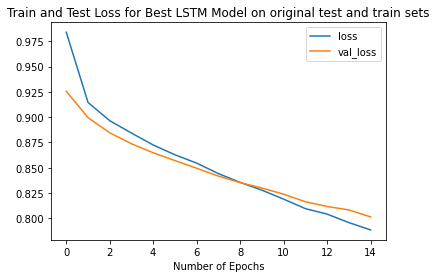

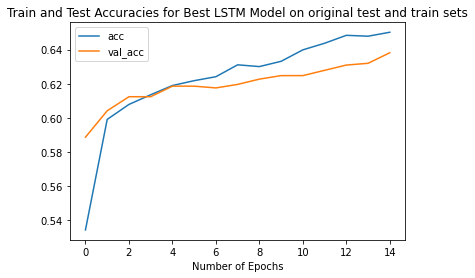

In [83]:
#graph

#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_best = pd.DataFrame(history_best.history)
ax = metrics_df_best[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss")
ax.set_title("Train and Test Loss for Best LSTM Model on original test and train sets")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_best[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies for Best LSTM Model on original test and train sets")
ax1.set_xlabel("Number of Epochs")

In [104]:
print("Mean Accuracy:" ,metrics_df_best['acc'].mean())
print("Mean Loss:" ,metrics_df_best['loss'].mean())
print("Mean Precision:" ,metrics_df_best['precision'].mean())
print("Mean Recall:" ,metrics_df_best['recall'].mean())
print("F1-Score:" , 2*((round(
    metrics_df_best['precision'].mean(),1)*round(metrics_df_best['recall'].mean(),1))/
                       (round(metrics_df_best['precision'].mean(),1)+round(metrics_df_best['recall'].mean(),1))))

Mean Accuracy: 0.622910209496816
Mean Loss: 0.8529744227727254
Mean Precision: 0.675714369614919
Mean Recall: 0.536033711830775
F1-Score: 0.5833333333333334


In [105]:
# Applying the final best model on the upsampled dataset 
#import the train and test files for financial news
fnews_Xtrain_bt = loadtxt('data/train/fnews_Xtrainbt_.csv', delimiter=',')
fnews_Xtest_bt = loadtxt('data/test/fnews_Xtestbt_.csv', delimiter=',')
fnews_ytrain_bt = loadtxt('data/train/fnews_ytrainbt_.csv',delimiter=',')
fnews_ytest_bt = loadtxt('data/test/fnews_ytestbt_.csv',delimiter=',')

#convert to array of integers from full precision
fnews_Xtrain_bt=fnews_Xtrain_bt.astype(int)
fnews_Xtest_bt=fnews_Xtest_bt.astype(int)
fnews_ytrain_bt=fnews_ytrain_bt.astype(int)
fnews_ytest_bt=fnews_ytest_bt.astype(int)

#import the weights
fnews_weights_bt = loadtxt('data/weights/weights_fnewsbt_.csv', delimiter=',')

In [106]:
#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain_bt.shape, 'ytrain:' ,fnews_ytrain_bt.shape)
print('Xtest:',fnews_Xtest_bt.shape, 'ytest:' ,fnews_ytest_bt.shape)

Xtrain: (7753, 58) ytrain: (7753, 3)
Xtest: (1939, 58) ytest: (1939, 3)


#### Reuse the best model we obtained from before for the upsampled data with the only change amde being the weights and input length in the embedding layer

In [109]:
# Applying the final best model on the train and test set 
def LSTM_Model_Best_upsampled():
    
    
    model = Sequential()
    #weights are changed respectively
    model.add(Embedding(fnews_weights_bt.shape[0],fnews_weights_bt.shape[1], weights = [fnews_weights_bt],
                       input_length = 58))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(38, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'acc'])
    
    return model

model = LSTM_Model_Best_upsampled()

In [110]:
start = time.time()
model= LSTM_Model_Best_upsampled()
#test on the upsampled stratified test and train
history_best_upsampled = model.fit(
    fnews_Xtrain_bt, 
    fnews_ytrain_bt, 
    epochs = 15,
    batch_size = 64,
    validation_data = (fnews_Xtest_bt, fnews_ytest_bt),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/15
122/122 [==============================] - 12s 65ms/step - loss: 0.9736 - accuracy: 0.5428 - precision: 0.6387 - recall: 0.3003 - acc: 0.5428 - val_loss: 0.9105 - val_accuracy: 0.5982 - val_precision: 0.6576 - val_recall: 0.4843 - val_acc: 0.5982
Epoch 2/15
122/122 [==============================] - 6s 52ms/step - loss: 0.8861 - accuracy: 0.6141 - precision: 0.6554 - recall: 0.5293 - acc: 0.6141 - val_loss: 0.8777 - val_accuracy: 0.6199 - val_precision: 0.6627 - val_recall: 0.5389 - val_acc: 0.6199
Epoch 3/15
122/122 [==============================] - 7s 56ms/step - loss: 0.8599 - accuracy: 0.6250 - precision: 0.6720 - recall: 0.5428 - acc: 0.6250 - val_loss: 0.8589 - val_accuracy: 0.6323 - val_precision: 0.6840 - val_recall: 0.5358 - val_acc: 0.6323
Epoch 4/15
122/122 [==============================] - 7s 59ms/step - loss: 0.8407 - accuracy: 0.6325 - precision: 0.6835 - recall: 0.5431 - acc: 0.6325 - val_loss: 0.8440 - val_accuracy: 0.6349 - val_precision: 0.6856 - val_reca

time taken: 137.21356439590454


Text(0.5, 0, 'Number of Epochs')

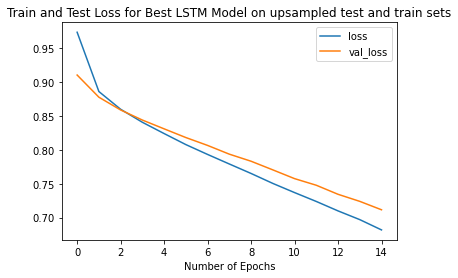

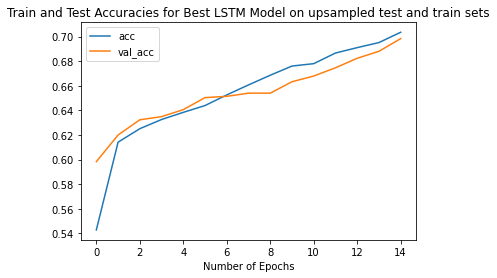

In [111]:
#graph

#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_best_upsampled = pd.DataFrame(history_best_upsampled.history)
ax = metrics_df_best_upsampled[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss")
ax.set_title("Train and Test Loss for Best LSTM Model on upsampled test and train sets")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_best_upsampled[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies for Best LSTM Model on upsampled test and train sets")
ax1.set_xlabel("Number of Epochs")

In [112]:
print("Mean Accuracy:" ,metrics_df_best_upsampled['acc'].mean())
print("Mean Loss:" ,metrics_df_best_upsampled['loss'].mean())
print("Mean Precision:" ,metrics_df_best_upsampled['precision'].mean())
print("Mean Recall:" ,metrics_df_best_upsampled['recall'].mean())
print("F1-Score:" , 2*((round(
    metrics_df_best_upsampled['precision'].mean(),1)*round(metrics_df_best_upsampled['recall'].mean(),1))/
                       (round(metrics_df_best_upsampled['precision'].mean(),1)+round(metrics_df_best_upsampled['recall'].mean(),1))))

Mean Accuracy: 0.6538888136545817
Mean Loss: 0.788658861319224
Mean Precision: 0.7108240882555644
Mean Recall: 0.5566361427307129
F1-Score: 0.6461538461538462


# LSTM-B

## Applying the best model on the upsampled Squidgame dataset

In [151]:
# Applying the final best model on the upsampled dataset 
#import the stratified train and test files for squidgame dataset
squidgame_Xtrain_bt = loadtxt('data/train/squidgame_Xtrainbt_.csv', delimiter=',')
squidgame_Xtest_bt = loadtxt('data/test/squidgame_Xtestbt_.csv', delimiter=',')
squidgame_ytrain_bt = loadtxt('data/train/squidgame_ytrainbt_.csv',delimiter=',')
squidgame_ytest_bt = loadtxt('data/test/squidgame_ytestbt_.csv',delimiter=',')

#convert to array of integers from full precision
squidgame_Xtrain_bt=squidgame_Xtrain_bt.astype(int)
squidgame_Xtest_bt=squidgame_Xtest_bt.astype(int)
squidgame_ytrain_bt=squidgame_ytrain_bt.astype(int)
squidgame_ytest_bt=squidgame_ytest_bt.astype(int)

#import the weights
squidgame_weights_bt = loadtxt('data/weights/weights_squidgamebt_.csv', delimiter=',')

In [152]:
#check the respective shape of the train and test sets
print('Xtrain:',squidgame_Xtrain_bt.shape, 'ytrain:' ,squidgame_ytrain_bt.shape)
print('Xtest:',squidgame_Xtest_bt.shape, 'ytest:' ,squidgame_ytest_bt.shape)

Xtrain: (1896, 758) ytrain: (1896, 3)
Xtest: (474, 758) ytest: (474, 3)


#### Reuse the best model we obtained from before for the upsampled data with the only change amde being the weights and input length in the embedding layer

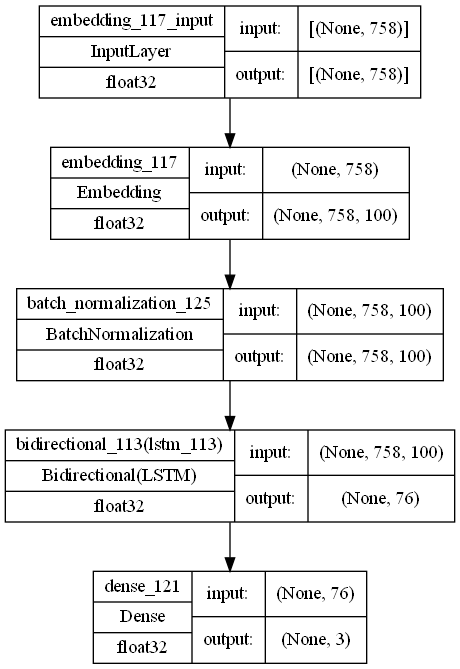

In [178]:
# Applying the final best model on the train and test set 
def LSTM_Model_Best_upsampled():
    
    
    model = Sequential()
    #weights are changed respectively
    model.add(Embedding(squidgame_weights_bt.shape[0],squidgame_weights_bt.shape[1], weights = [squidgame_weights_bt],
                       input_length = 758))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #reshape to match inpuits
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(38, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    
    return model

model = LSTM_Model_Best_upsampled()
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,)

In [181]:
start = time.time()
model= LSTM_Model_Best_upsampled()
#test on the upsampled stratified test and train
history_best_upsampled_sg = model.fit(
    squidgame_Xtrain_bt, 
    squidgame_ytrain_bt, 
    epochs = 15,
    batch_size = 64,
    validation_data = (squidgame_Xtest_bt,  squidgame_ytest_bt),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/15
30/30 [==============================] - 63s 2s/step - loss: 1.4492 - accuracy: 0.7732 - precision: 0.7996 - recall: 0.6967 - val_loss: 1.3710 - val_accuracy: 0.8038 - val_precision: 0.8038 - val_recall: 0.8038
Epoch 2/15
30/30 [==============================] - 58s 2s/step - loss: 1.3533 - accuracy: 0.8017 - precision: 0.8020 - recall: 0.8012 - val_loss: 1.3542 - val_accuracy: 0.8038 - val_precision: 0.8038 - val_recall: 0.8038
Epoch 3/15
30/30 [==============================] - 59s 2s/step - loss: 1.3261 - accuracy: 0.8012 - precision: 0.8019 - recall: 0.8006 - val_loss: 1.3356 - val_accuracy: 0.8038 - val_precision: 0.8038 - val_recall: 0.8038
Epoch 4/15
30/30 [==============================] - 62s 2s/step - loss: 1.2987 - accuracy: 0.8017 - precision: 0.8024 - recall: 0.8012 - val_loss: 1.3184 - val_accuracy: 0.8038 - val_precision: 0.8038 - val_recall: 0.8038
Epoch 5/15
30/30 [==============================] - 64s 2s/step - loss: 1.2725 - accuracy: 0.8017 - precision: 0

time taken: 1016.7371575832367


Text(0.5, 0, 'Number of Epochs')

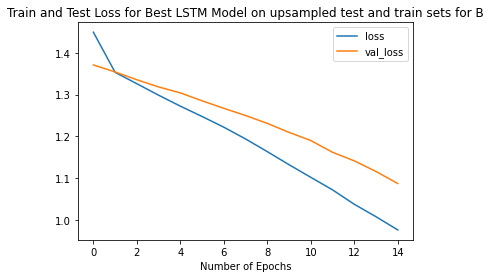

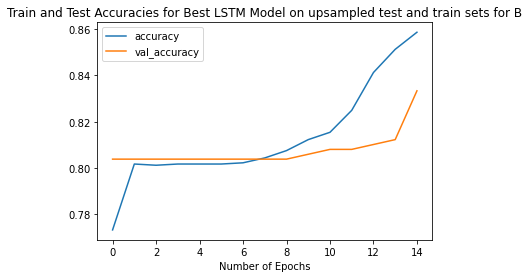

In [183]:
#graph

#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_best_upsampled_sg = pd.DataFrame(history_best_upsampled_sg.history)
ax = metrics_df_best_upsampled_sg[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss")
ax.set_title("Train and Test Loss for Best LSTM Model on upsampled test and train sets for B")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_best_upsampled_sg[["accuracy", "val_accuracy"]].plot()
ax1.set_title("Train and Test Accuracies for Best LSTM Model on upsampled test and train sets for B")
ax1.set_xlabel("Number of Epochs")

In [192]:
print("Mean Accuracy:" ,metrics_df_best_upsampled_sg['accuracy'].mean())
print("Mean Loss:" ,metrics_df_best_upsampled_sg['loss'].mean())
print("Mean Precision:" ,metrics_df_best_upsampled_sg['precision'].mean())
print("Mean Recall:" ,metrics_df_best_upsampled_sg['recall'].mean())
print("F1-Score:" , 2*((round(metrics_df_best_upsampled_sg['precision'].mean(),1)*round(metrics_df_best_upsampled_sg['recall'].mean(),1))/
                       (round(metrics_df_best_upsampled_sg['precision'].mean(),1)+round(metrics_df_best_upsampled_sg['recall'].mean(),1))))

Mean Accuracy: 0.8132559816042583
Mean Loss: 1.1904494166374207
Mean Precision: 0.8212987224260966
Mean Recall: 0.8032700379689535
F1-Score: 0.8000000000000002
